In [1]:
import matplotlib.pyplot as plt
import itertools


def plot_neural_input(res, position=15):
    plt.plot(res.e_.auditory_total_input[:, position], label="Auditory")
    plt.plot(res.e_.visual_total_input[:, position], label="Visual")
    plt.plot(res.e_.multi_total_input[:, position], label="Multisensory")
    plt.ylabel("Neural input", size=14)
    plt.xlabel("Time", size=14)
    plt.legend()
    plt.show()


def plot_res_per_soa(result_list, position=15):
    fig, axs = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True)
    idx = -1
    for res in result_list:
        idx += 1
        row, col = idx // 5, idx % 5
        sub_plot = res.plot.linet(position=15, ax=axs[row, col])
        sub_plot.get_legend().remove()
        sub_plot.set_title("SOA " + str(int(res.run_params.soa)) + " ms")

    handles, labels = sub_plot.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", borderaxespad=0.1)
    plt.subplots_adjust(right=0.935)
    plt.show()


def calculate_two_peaks_probability(visual_peaks_values):
    combinations = list(
        itertools.chain.from_iterable(
            itertools.combinations(visual_peaks_values, i + 2)
            for i in range(len(visual_peaks_values))
        )
    )

    probs_array = np.array([])

    for i in combinations:
        probs_array = np.append(probs_array, np.array(i).prod())

    return probs_array.sum() / probs_array.size

In [65]:
from scipy.optimize import curve_fit


def sig(x, a, b, c, d):
    """Compute sigmoidal value for the given delay.
    Args:
        x (1D np.array): Delay (ms).
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).

    Returns:
        sig (1D np.array): Vector with values for the given delay points.
    """
    return a + b / (1 + np.exp(-(x - c) / d))


def model_sig(x, c, d):
    """Compute sigmoidal value for the given delay.
    Args:
        x (1D np.array): Delay (ms).
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).

    Returns:
        sig (1D np.array): Vector with values for the given delay points.
    """
    global a
    global b

    return a + b / (1 + np.exp(-(x - c) / d))


## Sigmoid function fitting
def sigfit(x, y):
    """Fit the RT data to a sigmoidal function.

    Args:
        x (1D np.array): Delay (ms).
        y (1D np.array) : Values for the given delay points.

    Returns:
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).
    """

    # Obtains the upper and lower bounds
    global a
    global b

    # Defines starting points and boundaries for the fitting
    k_0 = (a - b) / (x[-1] - x[0])
    initial_slope = -(a - b) / (4 * k_0)
    # if initial_slope>=0: initial_slope=-0.0001
    middle_x = np.max(x) / 2
    init_guess = [middle_x, initial_slope]
    boundaries = ([36, float("-inf")], [204, 0])

    # Fits the data
    popt, _ = curve_fit(
        model_sig,
        x,
        y,
        p0=init_guess,
        method="trf",
        ftol=1e-8,
        xtol=1e-8,
        maxfev=100000,
        bounds=boundaries,
    )
    sigpar = np.asarray(popt)
    c = sigpar[0]
    d = sigpar[1]

    return c, d

In [62]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100

# Average data by group
avg_data = data.groupby(["Group", "Delay"])["Flashes"].aggregate(["mean"])
avg_data.reset_index(inplace=True)
avg_data.rename(columns={"mean": "Flashes (%)"}, inplace=True)
avg_data["Delay"] = avg_data.Delay.astype(float)

# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=14.6033, b=61.7941, c=86.2012, d=-27.569
        )
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=15.045, b=66.7106, c=59.806, d=-26.553
        )
        df_lspq = group[1]

soas = dataset.query("Group == 'L-SPQ'").sort_values(by=["Delay"])["Delay"].values
dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

,Group,Delay,Flashes (%),Fit
0,H-SPQ,108.0,35.357143,33.884199
1,H-SPQ,120.0,30.357143,28.623599
2,H-SPQ,132.0,27.142857,24.465345
3,H-SPQ,144.0,18.928571,21.365804
4,H-SPQ,156.0,18.214286,19.155035


In [95]:
from skneuromsi.neural import Paredes2022
import numpy as np
from findpeaks import findpeaks
from joblib import Parallel, delayed


def myjob_lspq(soa, cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau, l_ex):
    model = Paredes2022(
        time_range=(0, 550),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )
    res = model.run(
        auditory_intensity=2.425,
        visual_intensity=1.375,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        soa=soa,
        noise=False,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
        lateral_excitation=l_ex,
    )
    fp = findpeaks(method="topology", verbose=0, limit=0.15)
    fp_results = fp.fit(res.get_modes("visual").query("positions==15").visual.values)
    visual_peaks_df = fp_results["df"].query("peak==True & valley==False")
    if visual_peaks_df["score"].size < 2:
        p_two_flashes = 0
    else:
        p_two_flashes = calculate_two_peaks_probability(visual_peaks_df["y"].values)
    return p_two_flashes, res


with Parallel(n_jobs=-1) as parallel:
    par_res = parallel(
        delayed(myjob_lspq)(
            soa, 1.327e-02, 2.423e-01, 2.461e00, 6.712e00, 2.356e01, 1.175e02, 1.6
        )
        for soa in soas
    )

two_flashes = [i[0] for i in par_res]
results = [i[1] for i in par_res]

lspq_raw_model_data = np.array(two_flashes) * 100

with Parallel(n_jobs=-1) as parallel:
    par_res = parallel(
        delayed(myjob_lspq)(
            soa, 1.327e-02, 2.423e-01, 2.461e00, 6.712e00, 2.356e01, 1.175e02, 1.632e00
        )
        for soa in soas
    )

two_flashes = [i[0] for i in par_res]
results = [i[1] for i in par_res]

hspq_raw_model_data = np.array(two_flashes) * 100


with Parallel(n_jobs=-1) as parallel:
    par_res = parallel(
        delayed(myjob_lspq)(
            soa, 2.707e-02, 2.423e-01, 2.461e00, 6.712e00, 2.356e01, 1.175e02, 1.6
        )
        for soa in soas
    )

two_flashes = [i[0] for i in par_res]
results = [i[1] for i in par_res]

alter_hspq_raw_model_data = np.array(two_flashes) * 100

In [96]:
model_soas = np.linspace(soas[0], soas[-1], 100)

a, b = np.min(lspq_raw_model_data), np.max(lspq_raw_model_data)
lc, ld = sigfit(soas, lspq_raw_model_data)
lspq_model_data = sig(model_soas, a, b, lc, ld)

a, b = np.min(hspq_raw_model_data), np.max(hspq_raw_model_data)
hc, hd = sigfit(soas, hspq_raw_model_data)
hspq_model_data = sig(model_soas, a, b, hc, hd)

a, b = np.min(alter_hspq_raw_model_data), np.max(alter_hspq_raw_model_data)
alter_hc, alter_hd = sigfit(soas, alter_hspq_raw_model_data)
alter_hspq_model_data = sig(model_soas, a, b, alter_hc, alter_hd)

lspq_data = dataset.query("Group == 'L-SPQ' ").sort_values("Delay").Fit.values
hspq_data = dataset.query("Group == 'H-SPQ' ").sort_values("Delay").Fit.values

print("L-SPQ Model TWI:", lc)
print("H-SPQ Model TWI:", hc)
print("Alter H-SPQ Model TWI:", alter_hc)

L-SPQ Model TWI: 65.53682956928759
H-SPQ Model TWI: 81.6541805572442
Alter H-SPQ Model TWI: 82.54916587353198


In [52]:
import seaborn as sns

sns.set_context("paper")
sns.set_theme(
    style="ticks",
    palette="gray",
    rc={"axes.labelsize": 11, "axes.labelweight": "bold"},
)

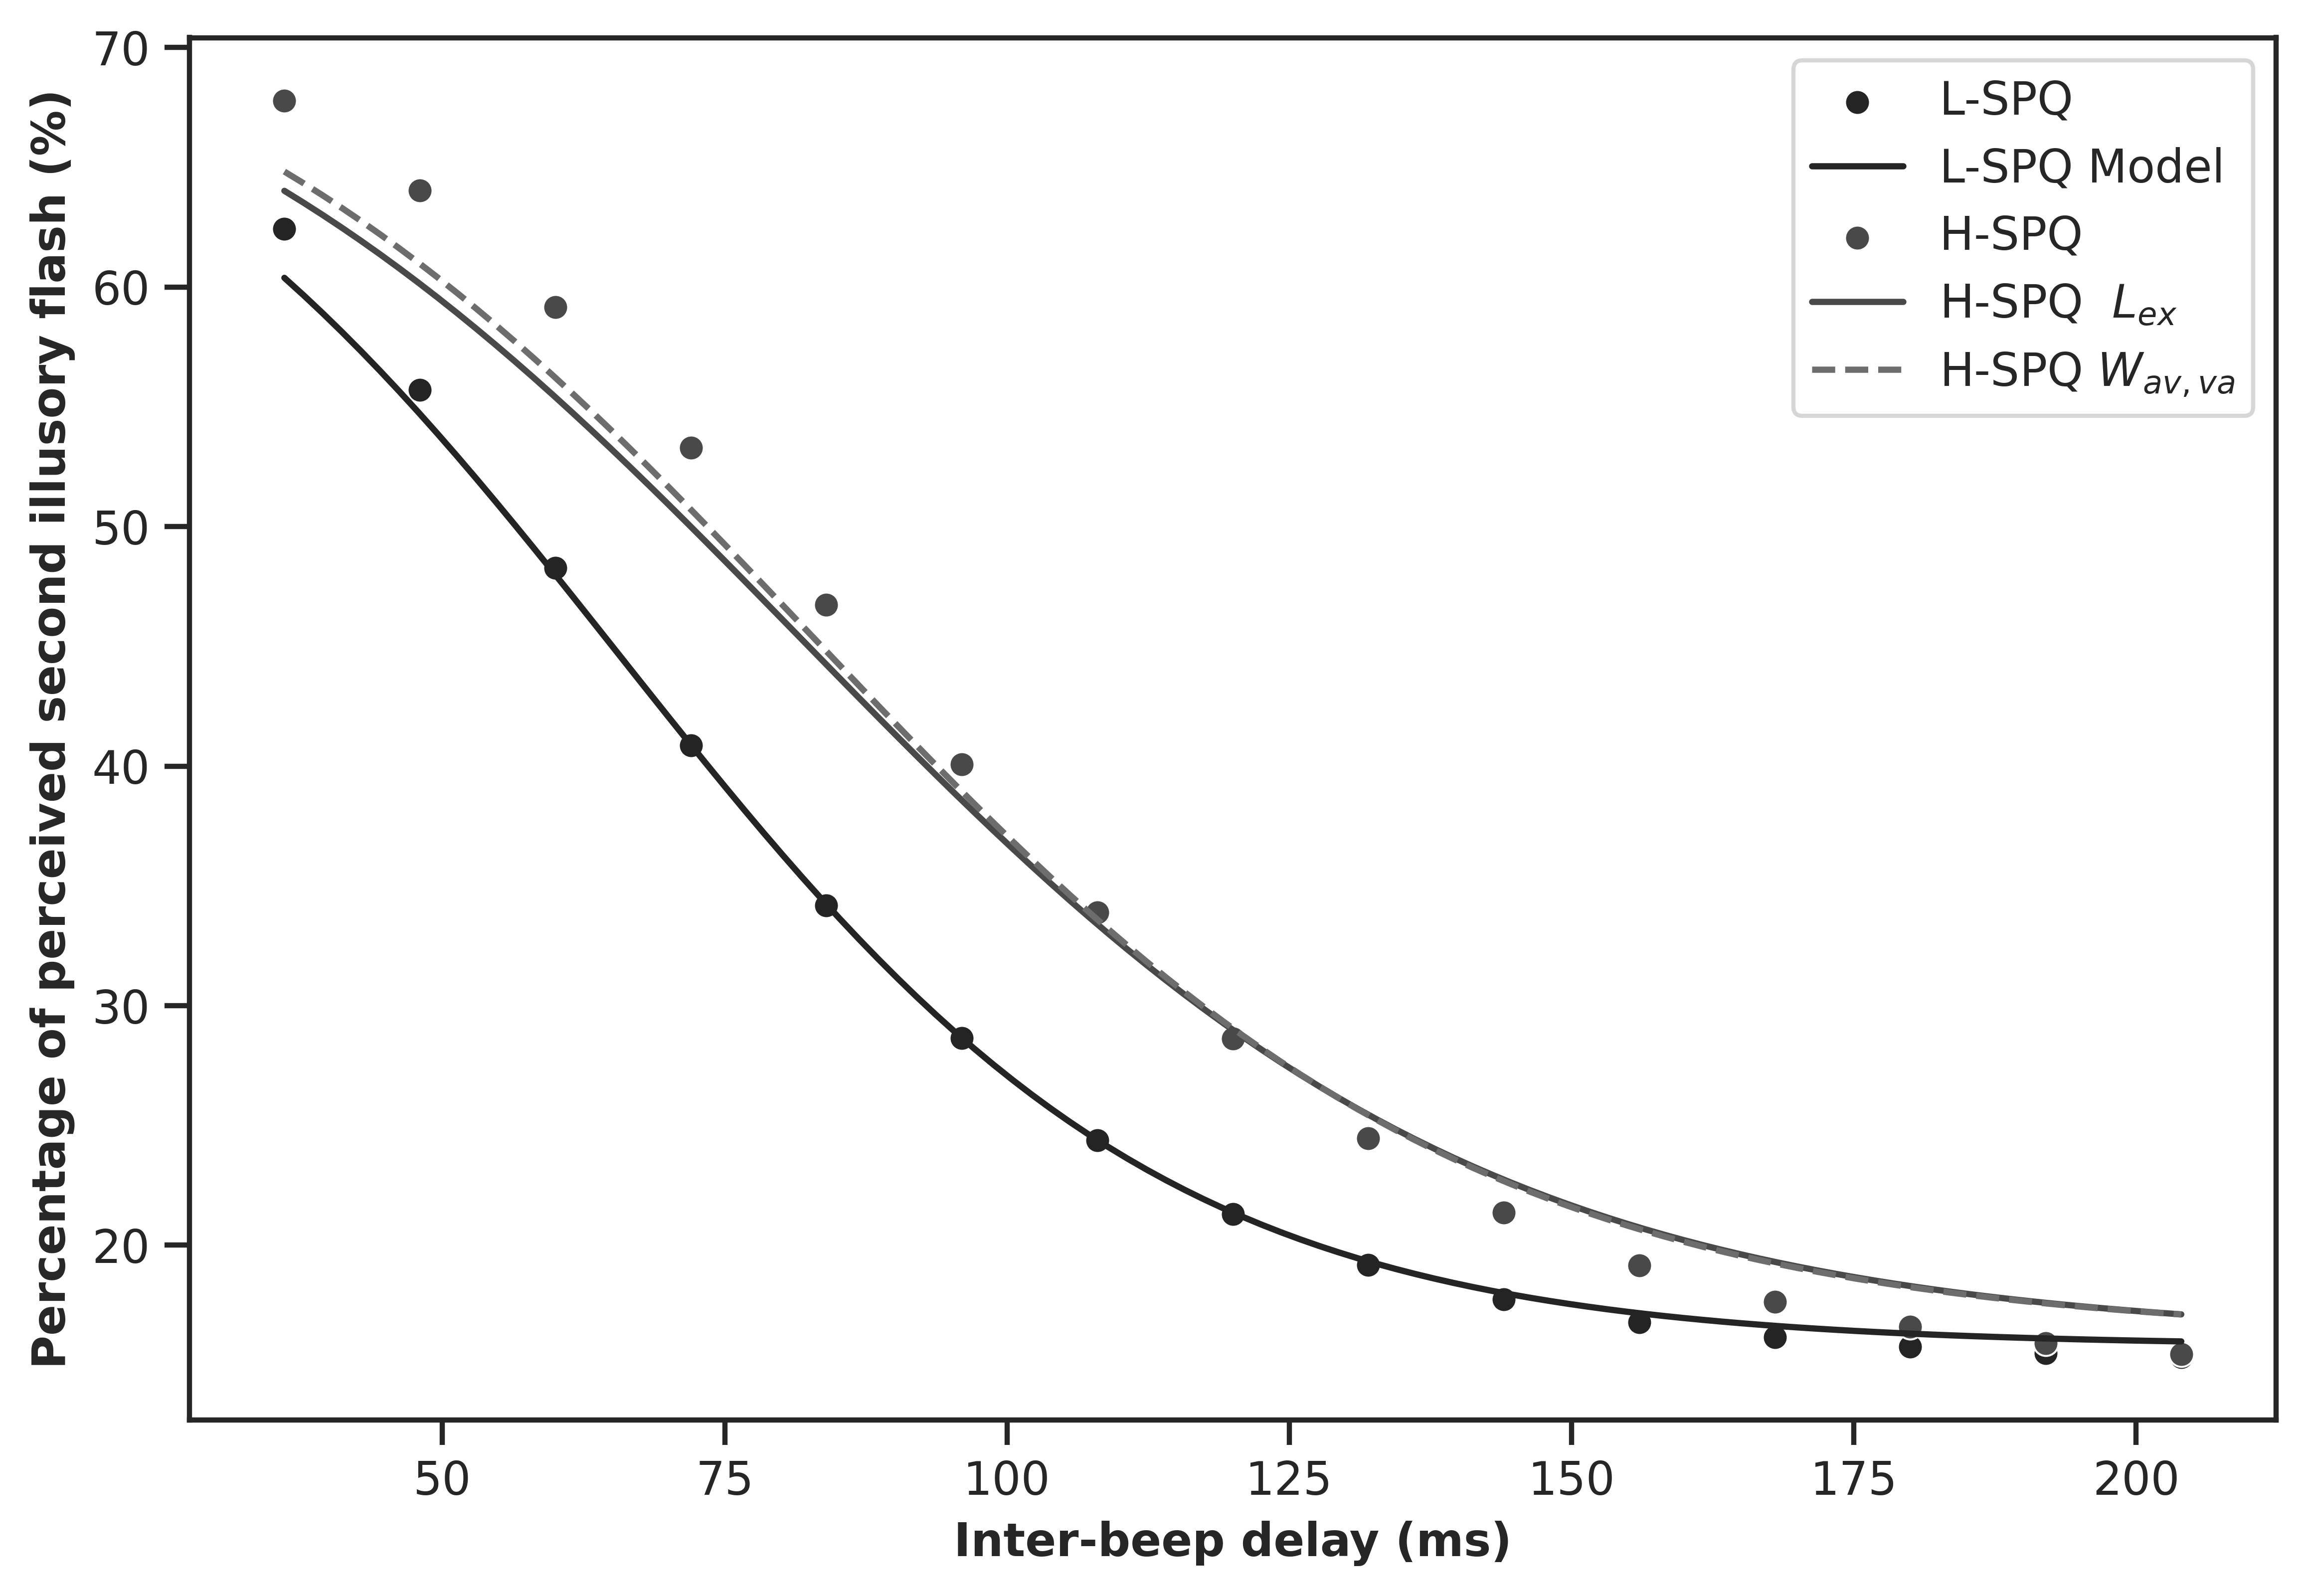

In [97]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6), dpi=600)
ax1 = plt.subplot(111)

sns.scatterplot(x=soas, y=lspq_data, label="L-SPQ", ax=ax1)
sns.lineplot(x=model_soas, y=lspq_model_data, label="L-SPQ Model", ax=ax1)
sns.scatterplot(x=soas, y=hspq_data, label="H-SPQ", ax=ax1)
sns.lineplot(x=model_soas, y=hspq_model_data, label="H-SPQ  $L_{ex}$", ax=ax1)
sns.lineplot(
    x=model_soas,
    y=alter_hspq_model_data,
    label="H-SPQ $W_{av,va}$",
    ax=ax1,
    linestyle="--",
)

ax1.set_xlabel("Inter-beep delay (ms)")
ax1.set_ylabel("Percentage of perceived second illusory flash (%)")

fig.savefig("drafts/FIG3.eps", bbox_inches="tight", format="eps")